In [152]:
import random
import gurobipy as gp
from gurobipy import GRB
import copy
import numpy as np

n=10
def generate_data(n):
    # Initializing an empty adjacency matrix with zeros
    W = [[0] * n for _ in range(n)]

    # Generate random edge weights (assuming non-negative weights)
    for i in range(n):
        for j in range(i+1, n):
            t = random.randint(0,2)
            if t == 0:
                weight = 0
            else:
                weight = random.randint(1,10)
            # weight = random.uniform(0, 2)  # Adjust the range as needed
            # Ensure that edges are undirected by setting W[i][j] = W[j][i] = weight
            W[i][j] = W[j][i] = weight
    return W

In [153]:
def BP(W,n):
    # Create a new model
    m = gp.Model("mip1")
    # Create variable

    x = {}
    x = m.addVars(range(n),vtype = "B", name="x")
    y = m.addVars(range(n),range(n),vtype = "B", name="y")

    m.setObjective(sum(W[i][j]*y[i,j] for i in range(n) for j in range(n)), GRB.MAXIMIZE)
    m.addConstrs(y[i,j]<=(x[i]+x[j]) for i in range(n) for j in range(n))
    m.addConstrs(y[i,j]+x[i]+x[j]<=2 for i in range(n) for j in range(n))
    m.optimize()
    y_result=[]

    for v in x.values():
        if v.X == 0 or v.X==-0:
            y_result.append(0)
        else:
            y_result.append(1)
    return y_result

In [154]:
def count_weight(W:list, A:list, B:list):
    total_weight = 0
    for i in A:
        for j in B:
            total_weight += W[i][j]
    return total_weight

In [155]:
def weight_change(W, A, B, current_weight):
    weight_change_list = []
    for i in range(n):
        temp_A = A.copy()
        temp_B = B.copy()
        if i in A:

            temp_B.append(i)
            temp_A.remove(i)
        else:

            temp_A.append(i)
            temp_B.remove(i)
        new_weight = count_weight(W, temp_A, temp_B)
        result = new_weight - current_weight
        weight_change_list.append(result)
    return weight_change_list

In [156]:
def random_set():
    A = []
    B = []
    xdata_gh = []

    for i in range(n):
        r = random.randint(0,1)
        if r == 0:
            xdata_gh.append(0)
            A.append(i)
        else:
            xdata_gh.append(1)
            B.append(i)
    return xdata_gh, A, B

In [157]:
def GH(W, A, B, n):
    total_weight = count_weight(W, A, B)

    for i in range(n):
        temp_A = A.copy()
        temp_B = B.copy()
        if i in A:
            temp_B.append(i)
            temp_A.remove(i)
        else:
            temp_A.append(i)
            temp_B.remove(i)
        new_weight = count_weight(W, temp_A, temp_B)
        if new_weight >= total_weight:
            A = temp_A
            B = temp_B
            total_weight = new_weight
    A = sorted(A)
    B = sorted(B)
    total_weight = count_weight(W, A, B)
    return total_weight, A, B

In [158]:
def get_data(k):
    A_GH_list = []
    B_GH_list = []
    gh_weight_list = []
    raw_data = []
    xdata1_l = []
    ydata1_l = []

    for i in range(k):
        sum_W = []
        data_list = []
        data = generate_data(n)

        xdata_gh, A, B = random_set()
        gh_weight, A_GH, B_GH = GH(data,A,B,n)

        A_GH_list.append(A_GH)
        B_GH_list.append(B_GH)
        gh_weight_list.append(gh_weight)

        current_weight = count_weight(data,A,B)
        weight_diff = weight_change(data,A,B,current_weight)

        result = BP(data, n)
        ydata1_l.append(result)
        
        for j in data:
            sum_W.append(sum(j))
        data_list.append(sum_W)
        # data_list.append(xdata_gh)
        # data_list.append(weight_diff)
        xdata1_l.append(data_list)
        raw_data.append(data)

    return xdata1_l, ydata1_l, A_GH_list, B_GH_list, gh_weight_list, raw_data

In [159]:
k1 = 500
xtrain_list, ytrain_list, A_GH_train, B_GH_train, gh_weight_train, raw_data = get_data(k1)

k2 = 100
xtest_list, ytest_list, A_GH_test, B_GH_test, gh_weight_test, raw_data = get_data(k2)

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-8565U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 200 rows, 110 columns and 580 nonzeros
Model fingerprint: 0x50f1925f
Variable types: 0 continuous, 110 integer (110 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 142 rows and 71 columns
Presolve time: 0.00s
Presolved: 58 rows, 39 columns, 174 nonzeros
Variable types: 0 continuous, 39 integer (39 binary)
Found heuristic solution: objective 148.0000000

Root relaxation: objective 3.320000e+02, 12 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd  

Cutting planes:
  Zero half: 6
  RLT: 28

Explored 1 nodes (89 simplex iterations) in 0.06 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 6: 296 254 244 ... -0

Optimal solution found (tolerance 1.00e-04)
Best objective 2.960000000000e+02, best bound 2.960000000000e+02, gap 0.0000%
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-8565U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 200 rows, 110 columns and 580 nonzeros
Model fingerprint: 0xdfc77c7d
Variable types: 0 continuous, 110 integer (110 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 138 rows and 69 columns
Presolve time: 0.00s
Presolved: 62 rows, 41 columns, 186 nonz

In [160]:
A_BP = []
B_BP = []

for i in ytest_list:
    temp_A = []
    temp_B = []
    for j in range(len(i)):
        if i[j]>0.5:
            temp_A.append(j)
        else:
            temp_B.append(j)
    A_BP.append(temp_A)
    B_BP.append(temp_B)

In [161]:
BP_result = 0
GH_result = 0
for i in range(len(A_BP)):
    GH_weight = count_weight(raw_data[i], A_GH_test[i], B_GH_test[i])
    BP_weight = count_weight(raw_data[i], A_BP[i], B_BP[i])
    if BP_weight >= GH_weight:
        BP_result += 1
    else:
        GH_result += 1

print(f"Outcome of the BP where they have a higher performance is {BP_result/len(A_BP)}%")
print(f"Outcome of the GH where they have a higher performance is {GH_result/len(A_BP)}%")

Outcome of the BP where they have a higher performance is 1.0%
Outcome of the GH where they have a higher performance is 0.0%


In [162]:
xtrain = np.array(xtrain_list)
xtest = np.array(xtest_list)
ytrain = np.array(ytrain_list)
ytest = np.array(ytest_list)

In [163]:
def precision(y_true, y_pred):

    from tensorflow.keras import backend as K
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):

    from tensorflow.keras import backend as K
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fbeta(y_true, y_pred, beta=1):

    from tensorflow.keras import backend as K
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')

    # If there are no true positives, fix the F score at 0 like sklearn.
    #if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
    #    return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score


def f1score(y_true, y_pred):

    return fbeta(y_true, y_pred, beta=1)

In [164]:
import datetime
import tensorflow as tf

from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(patience=2, restore_best_weights=True)

In [165]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

tf.random.set_seed(42)
log_dir = "logs/fit/" + "single_layer"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

xtrain=np.reshape(xtrain,[k1, n])
xtest=np.reshape(xtest,[k2, n])

input_shape = (n, )
nrlayers = 1
nrnodes = [10]
rate = 0.002

model = keras.Sequential()
numclasses = n

for i in range(nrlayers + 1):
    if (i == 0):
        # input layer
        model.add(keras.Input(shape=input_shape))
    else:
        # hidden layers
        nrnode = nrnodes[i - 1]
        model.add(keras.layers.Dense(nrnode, activation="relu"))

model.add(keras.layers.Dense(numclasses, activation="sigmoid"))

model.summary()

batch_size = 30 # Based on SGD --> 1 gradient is calculated using 32 data points every time
#so in each epoch, training_size/batch_size many gradient calculations and weight updates
epochs = 5 # How many times to go through the data to complete the SGD

opt = keras.optimizers.SGD(learning_rate=rate)
model.compile(loss="binary_crossentropy",
                optimizer=opt,
                metrics=[f1score, 'accuracy'])

history = model.fit(xtrain, ytrain, batch_size=batch_size, epochs=epochs, validation_split=0.1,)

score_train = model.evaluate(xtrain, ytrain, verbose=1)
print(f"Train loss: {score_train[0]}, Train accuracy:, {score_train[1]}")

score = model.evaluate(xtest, ytest, verbose=1)
print(f"Test loss: {score[0]}, Test accuracy:, {score[1]}")

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 10)                110       
                                                                 
 dense_15 (Dense)            (None, 10)                110       
                                                                 
Total params: 220 (880.00 Byte)
Trainable params: 220 (880.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
15/15 [==============================] - 3s 79ms/step - loss: 2.5354 - f1score: 0.5386 - accuracy: 0.1622 - val_loss: 1.9627 - val_f1score: 0.4910 - val_accuracy: 0.1000
Epoch 2/5
15/15 [==============================] - 0s 9ms/step - loss: 1.2540 - f1score: 0.5304 - accuracy: 0.0911 - val_loss: 1.2368 - val_f1score: 0.4854 - val_accuracy: 0.1000
Epoch 3/5
15/15 [==============================] - 0s

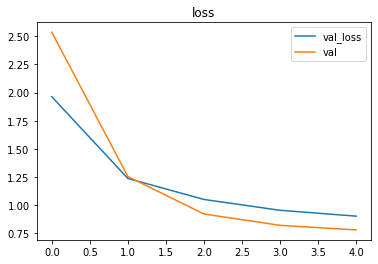

In [166]:
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['loss'], label='val')
plt.title('loss')
plt.legend()

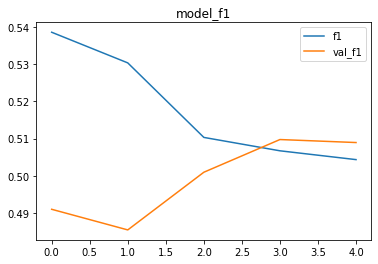

In [167]:
plt.plot(history.history['f1score'], label = 'f1')
plt.plot(history.history['val_f1score'], label = 'val_f1')
plt.title('model_f1')
plt.legend()

In [168]:
# import matplotlib.pyplot as plt

# plt.plot(history.history['accuracy'], label = 'accuracy')
# plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
# plt.title('model_accuracy')
# plt.legend()


In [169]:
pred_f = model.predict(xtest)
pred = pred_f.tolist()
pred = [[round(x) for x in sublist] for sublist in pred]
print(accuracy_score(pred,ytest)*100)

4/4 [==============================] - 0s 2ms/step
0.0


In [170]:
# models1.predict(xtest)
# NN = models1.predict(xtest)
# NN_ytest = NN.tolist()
# NN_ytest = [[int(x) for x in sublist] for sublist in NN_ytest]

In [171]:
A_NN = []
B_NN = []

for i in pred:
    temp_A = []
    temp_B = []
    for j in range(len(i)):
        if i[j]>0.5:
            temp_A.append(j)
        else:
            temp_B.append(j)
    A_NN.append(temp_A)
    B_NN.append(temp_B)

In [172]:
print(A_NN[0:5])
print()
print(B_NN[0:5])

[[1, 3, 4, 6, 7], [1, 3, 4, 6, 7], [1, 3, 4, 6, 7], [1, 3, 4, 6, 7], [1, 3, 4, 6, 7]]

[[0, 2, 5, 8, 9], [0, 2, 5, 8, 9], [0, 2, 5, 8, 9], [0, 2, 5, 8, 9], [0, 2, 5, 8, 9]]


In [173]:
pred

[[0, 1, 0, 1, 1, 0, 1, 1, 0, 0],
 [0, 1, 0, 1, 1, 0, 1, 1, 0, 0],
 [0, 1, 0, 1, 1, 0, 1, 1, 0, 0],
 [0, 1, 0, 1, 1, 0, 1, 1, 0, 0],
 [0, 1, 0, 1, 1, 0, 1, 1, 0, 0],
 [0, 1, 0, 1, 1, 0, 1, 1, 0, 0],
 [1, 1, 0, 0, 0, 1, 1, 0, 0, 0],
 [1, 1, 0, 0, 0, 1, 1, 1, 0, 0],
 [1, 1, 1, 0, 1, 1, 1, 0, 1, 0],
 [0, 1, 0, 0, 1, 1, 0, 0, 1, 0],
 [0, 1, 0, 1, 1, 0, 1, 1, 0, 0],
 [1, 1, 0, 0, 0, 1, 1, 0, 0, 0],
 [0, 1, 0, 1, 1, 0, 1, 1, 0, 0],
 [0, 1, 0, 1, 1, 0, 1, 1, 0, 0],
 [0, 1, 0, 1, 1, 0, 1, 1, 0, 0],
 [1, 1, 0, 0, 0, 0, 0, 1, 1, 1],
 [0, 1, 0, 1, 1, 0, 1, 1, 0, 0],
 [1, 0, 1, 1, 0, 1, 0, 0, 1, 1],
 [1, 1, 1, 1, 1, 0, 0, 0, 1, 1],
 [1, 1, 0, 0, 0, 1, 1, 0, 0, 0],
 [0, 1, 0, 1, 1, 0, 1, 1, 0, 0],
 [1, 1, 0, 0, 0, 0, 0, 1, 0, 1],
 [0, 1, 0, 1, 1, 0, 1, 1, 0, 0],
 [0, 1, 0, 1, 1, 0, 1, 1, 0, 0],
 [1, 1, 1, 0, 1, 1, 1, 0, 1, 0],
 [0, 1, 0, 1, 1, 0, 1, 1, 0, 0],
 [0, 1, 0, 1, 1, 0, 1, 1, 0, 0],
 [0, 1, 0, 1, 1, 0, 1, 1, 0, 0],
 [1, 1, 1, 0, 1, 1, 1, 0, 1, 0],
 [1, 1, 1, 1, 1, 0, 0, 0, 1, 1],
 [0, 1, 0,

In [174]:
NN_result = 0
GH_result = 0
for i in range(len(A_NN)):
    GH_weight = count_weight(raw_data[i], A_GH_test[i], B_GH_test[i])
    NN_weight = count_weight(raw_data[i], A_NN[i], B_NN[i])
    print(f"GH_weight is {GH_weight}")
    print(f"NN_weight is {NN_weight}")
    print()
    if NN_weight >= GH_weight:
        NN_result += 1
    else:
        GH_result += 1

print(f"Outcome of the MLGH where they have a higher performance is {NN_result/len(A_NN)}%")
print(f"Outcome of the GH where they have a higher performance is {GH_result/len(A_NN)}%")

GH_weight is 82
NN_weight is 50

GH_weight is 115
NN_weight is 95

GH_weight is 138
NN_weight is 116

GH_weight is 117
NN_weight is 107

GH_weight is 110
NN_weight is 95

GH_weight is 117
NN_weight is 116

GH_weight is 104
NN_weight is 85

GH_weight is 120
NN_weight is 97

GH_weight is 123
NN_weight is 112

GH_weight is 115
NN_weight is 96

GH_weight is 121
NN_weight is 79

GH_weight is 118
NN_weight is 107

GH_weight is 133
NN_weight is 107

GH_weight is 138
NN_weight is 133

GH_weight is 105
NN_weight is 107

GH_weight is 84
NN_weight is 94

GH_weight is 107
NN_weight is 92

GH_weight is 133
NN_weight is 103

GH_weight is 102
NN_weight is 76

GH_weight is 131
NN_weight is 104

GH_weight is 118
NN_weight is 118

GH_weight is 110
NN_weight is 76

GH_weight is 86
NN_weight is 90

GH_weight is 109
NN_weight is 106

GH_weight is 86
NN_weight is 72

GH_weight is 91
NN_weight is 76

GH_weight is 129
NN_weight is 106

GH_weight is 126
NN_weight is 90

GH_weight is 109
NN_weight is 93

GH_wei